# Import dependencies

In [27]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
from sklearn.metrics import r2_score
from scipy.stats import linregress

# Data Cleaning

In [28]:
# Read in the csv file
df = pd.read_csv('stroke_cleaned_v2.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,stroke
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,1
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,NaN,1
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,1
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,1
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,1


In [29]:
# Summary statistics of main df
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,4908.00000,5109.000000
mean,36513.985516,43.241143,0.097475,0.054022,106.140399,28.89456,0.048738
std,21162.008804,22.592882,0.296633,0.226084,45.285004,7.85432,0.215340
min,67.000000,1.000000,0.000000,0.000000,55.120000,10.30000,0.000000
25%,17740.000000,25.000000,0.000000,0.000000,77.240000,23.50000,0.000000
50%,36922.000000,45.000000,0.000000,0.000000,91.880000,28.10000,0.000000
75%,54643.000000,61.000000,0.000000,0.000000,114.090000,33.10000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.60000,1.000000


In [30]:
# Check what needs to be cleaned
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5109 non-null   int64  
 1   gender             5109 non-null   object 
 2   age                5109 non-null   int64  
 3   hypertension       5109 non-null   int64  
 4   heart_disease      5109 non-null   int64  
 5   ever_married       5109 non-null   object 
 6   work_type          5109 non-null   object 
 7   residence_type     5109 non-null   object 
 8   avg_glucose_level  5109 non-null   float64
 9   bmi                4908 non-null   float64
 10  stroke             5109 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 439.2+ KB


In [31]:
# Cleaning data
# Drop the NaN values
cleaned_df = df.dropna()

# Checking if BMI is normally distributed
print(cleaned_df['bmi'].describe())

count    4908.00000
mean       28.89456
std         7.85432
min        10.30000
25%        23.50000
50%        28.10000
75%        33.10000
max        97.60000
Name: bmi, dtype: float64


Skewness: The mean (28.8633) is not exactly at the center between the minimum (10.3) and maximum (97.6) values. This suggests some degree of skewness in the distribution.

Standard Deviation: The standard deviation (7.699785) indicates a moderate amount of variability in the data. However, it does not provide direct information about the shape of the distribution.

Quartiles: The quartiles (25%, 50%, and 75%) provide information about the spread of the data, and the difference between the 25th and 75th percentiles suggests some degree of interquartile range.

Therefore the median shall be used to replace NaN values in BMI column.

In [32]:
# BMI Column
# Replace "N/A" with median in the 'bmi' column
median_bmi = cleaned_df['bmi'].median()
cleaned_df['bmi'] = cleaned_df['bmi'].fillna(median_bmi)

# Drop rows with missing values in the 'bmi' column
cleaned_df = cleaned_df.dropna(subset=['bmi'])

# Gender Column
# Drop rows with 'Other' in the 'gender' column
cleaned_df = cleaned_df[cleaned_df['gender'] != 'Other']

C:\Users\sophi\AppData\Local\Temp\ipykernel_20296\4277025733.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['bmi'] = cleaned_df['bmi'].fillna(median_bmi)


In [7]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4908 entries, 0 to 5108
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4908 non-null   int64  
 1   gender             4908 non-null   object 
 2   age                4908 non-null   int64  
 3   hypertension       4908 non-null   int64  
 4   heart_disease      4908 non-null   int64  
 5   ever_married       4908 non-null   object 
 6   work_type          4908 non-null   object 
 7   residence_type     4908 non-null   object 
 8   avg_glucose_level  4908 non-null   float64
 9   bmi                4908 non-null   float64
 10  stroke             4908 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 460.1+ KB


In [8]:
cleaned_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,stroke
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,1
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,1
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,1
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,1
5,56669,Male,81,0,0,Yes,Private,Urban,186.21,29.0,1


# Visualisations

Exploration of which features are more likely to influence a patient having a stroke

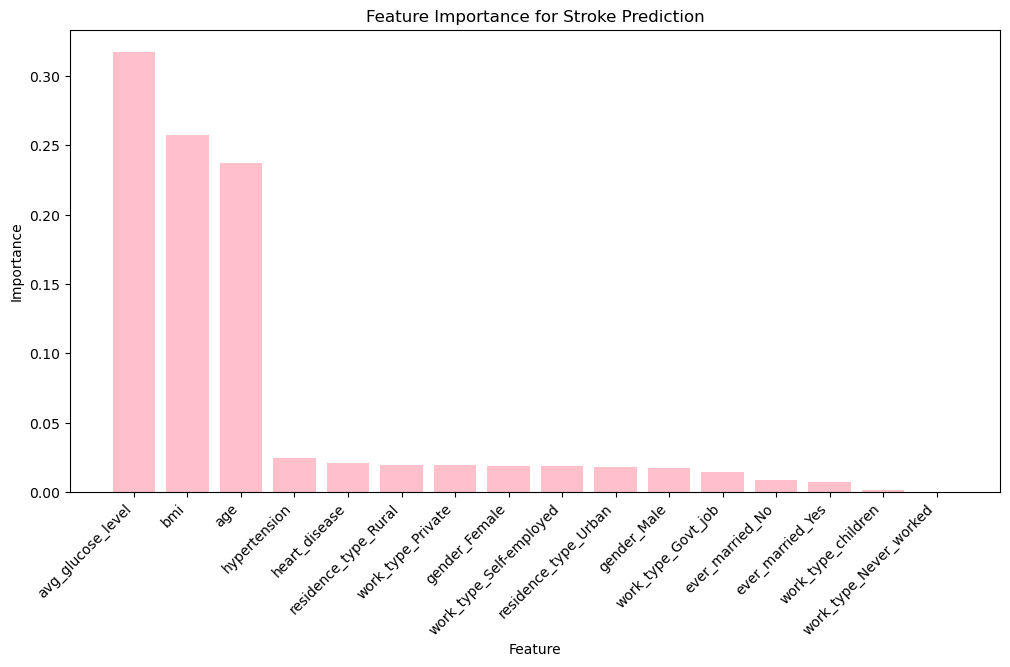

In [9]:
# Set stroke as target variable
X = cleaned_df.drop(['id', 'stroke'], axis=1)
y = cleaned_df['stroke']

# Convert categorical variables to numerical
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use RandomForestClassifier for feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Get feature names
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='pink')
plt.title('Feature Importance for Stroke Prediction')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')

# Save Figure
plt.savefig('Images/feature_importance.pdf')
plt.show()

In [10]:
feature_importance_df

,Feature,Importance
3,avg_glucose_level,0.317525
4,bmi,0.257377
0,age,0.236959
1,hypertension,0.024329
2,heart_disease,0.021025
14,residence_type_Rural,0.019743
11,work_type_Private,0.019312
5,gender_Female,0.018757
12,work_type_Self-employed,0.018384
15,residence_type_Urban,0.017991


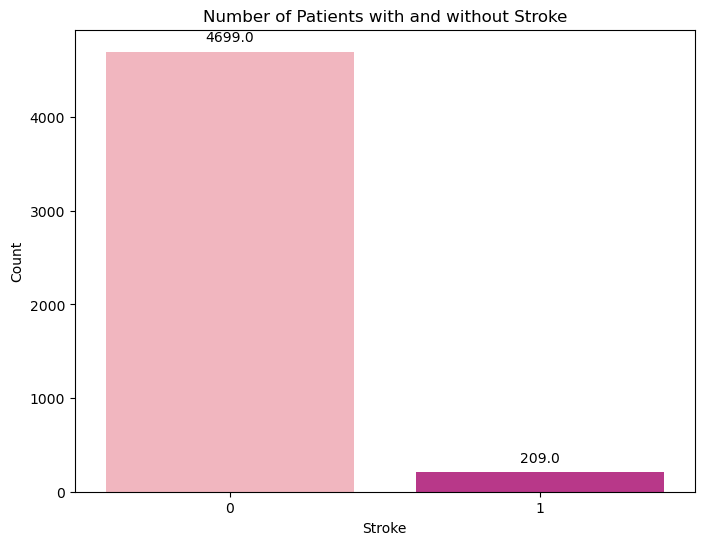

In [11]:
# Create a count bar chart for the 'stroke' variable
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='stroke', data=cleaned_df, palette='RdPu')
plt.title('Number of Patients with and without Stroke')
plt.xlabel('Stroke')
plt.ylabel('Count')

# Annotate the bars with counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Save Figure
plt.savefig('Images/stroke_count_bar_chart.pdf')

plt.show()

## Correlation Heatmap

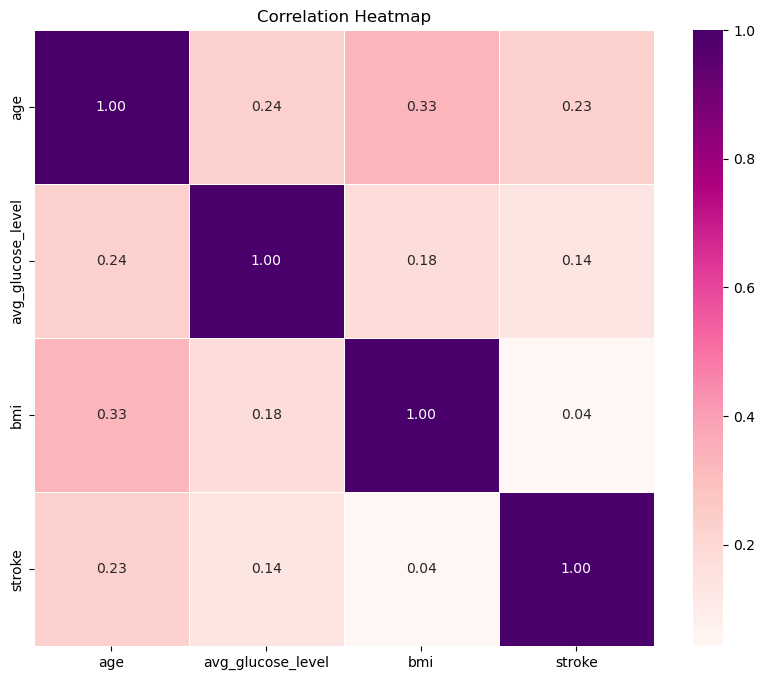

In [12]:
# Select relevant columns for correlation
correlation_data = cleaned_df[['age', 'avg_glucose_level', 'bmi', 'stroke']]

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdPu', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')

# Save Figure
plt.savefig('Images/correlation_heatmap.pdf')
plt.show()



In [13]:
correlation_matrix

,age,avg_glucose_level,bmi,stroke
age,1.000000,0.236098,0.332948,0.232419
avg_glucose_level,0.236098,1.000000,0.175672,0.138984
bmi,0.332948,0.175672,1.000000,0.042341
stroke,0.232419,0.138984,0.042341,1.000000


# Age vs stroke incidence
In this section, we examine the association between age and stroke risk. Through visualizations and statistical insights, we explore how age influences the likelihood of experiencing a stroke, shedding light on key patterns and distributions within our dataset

## Histogram for the distribution of strokes

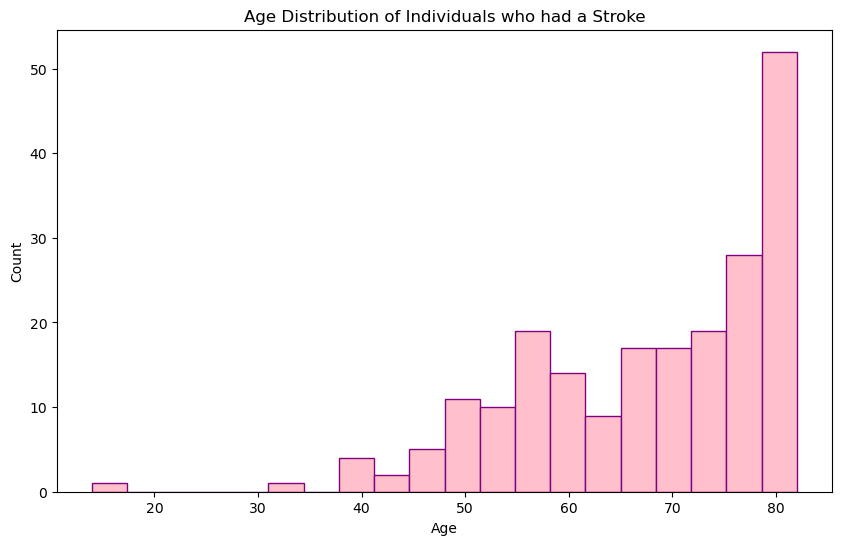

In [14]:
# Filter data to include only those who had a stroke
stroke_data = cleaned_df[cleaned_df['stroke'] == 1]

# Age distribution for individuals who had a stroke
plt.figure(figsize=(10, 6))
plt.hist(stroke_data['age'], bins=20, color='pink', edgecolor='purple')
plt.title('Age Distribution of Individuals who had a Stroke')
plt.xlabel('Age')
plt.ylabel('Count')

# Save Figure
plt.savefig('Images/age_distribution_hist.pdf')
plt.show()

## Maliha Age Distribution code

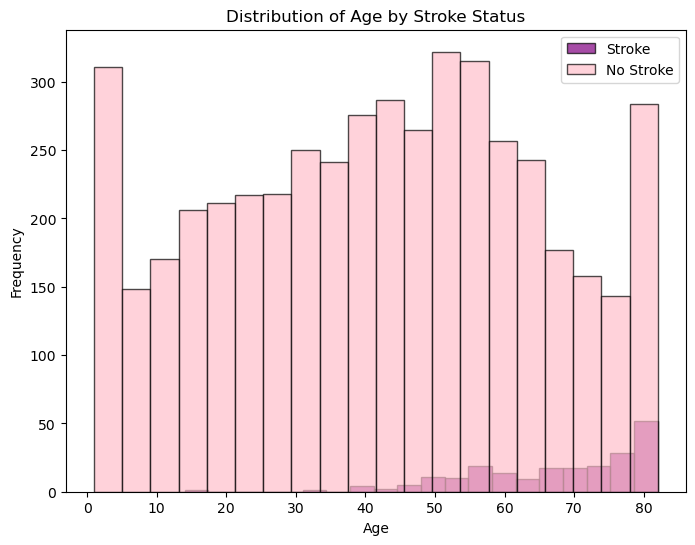

In [15]:
# Distribution of age vs stroke status
stroke_data = cleaned_df[cleaned_df['stroke'] == 1]['age'].dropna()
no_stroke_data = cleaned_df[cleaned_df['stroke'] == 0]['age'].dropna()

# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(stroke_data, bins=20, color='purple', alpha=0.7, label='Stroke', edgecolor='black')
plt.hist(no_stroke_data, bins=20, color='pink', alpha=0.7, label='No Stroke', edgecolor='black')
plt.title('Distribution of Age by Stroke Status')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

# Save Figure
plt.savefig('Images/age_distribution_hist_v2.pdf')
plt.show()

## Line Plot of Age and Stroke Proportion

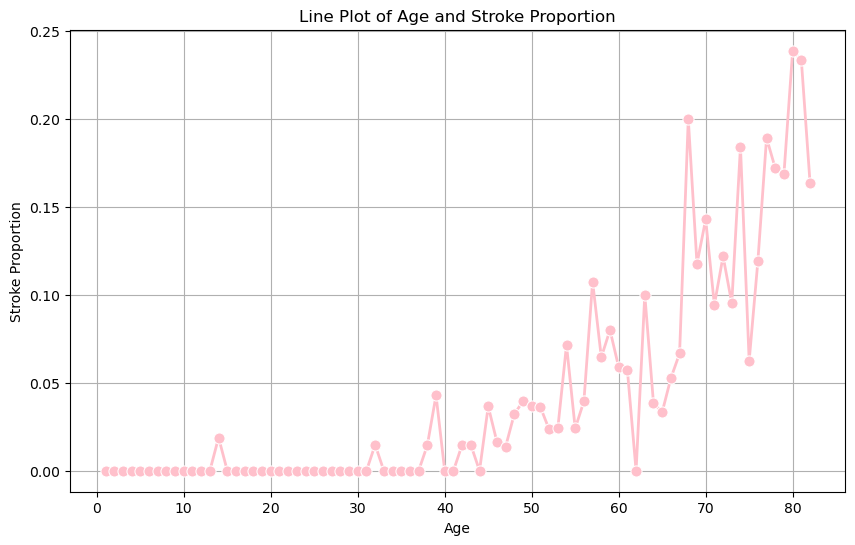

In [16]:
# Understanding how stroke risk increases with age
# Group by age and stroke incidence and get mean 
age_stroke_proportion = cleaned_df.groupby('age')['stroke'].mean().reset_index()

# Create a line plot for the relationship between age and stroke proportion
plt.figure(figsize=(10, 6))
sns.lineplot(x='age', y='stroke', data=age_stroke_proportion, marker='o', markersize=8, color='pink', linewidth=2)
plt.title('Line Plot of Age and Stroke Proportion')
plt.xlabel('Age')
plt.ylabel('Stroke Proportion')
plt.grid(True)

# Save Figure
plt.savefig('Images/age_stroke_line_plot.pdf')
plt.show()

In [17]:
# Calculate summary statistics for age with and without strokes
age_summary_with_stroke = cleaned_df[cleaned_df['stroke'] == 1]['age'].describe()
age_summary_without_stroke = cleaned_df[cleaned_df['stroke'] == 0]['age'].describe()

# Display the summary statistics
print("With Stroke:")
print(age_summary_with_stroke)
print("\nWithout Stroke:")
print(age_summary_without_stroke)

With Stroke:
count    209.000000
mean      67.712919
std       12.402848
min       14.000000
25%       58.000000
50%       70.000000
75%       78.000000
max       82.000000
Name: age, dtype: float64

Without Stroke:
count    4699.000000
mean       41.775271
std        22.248465
min         1.000000
25%        24.000000
50%        43.000000
75%        59.000000
max        82.000000
Name: age, dtype: float64


Individuals with a stroke, on average, are older than those without a stroke, as indicated by the higher mean age.

The age distribution among individuals with a stroke is narrower, with a lower standard deviation, suggesting less variability in age within this group.

The minimum age values for both groups (1.32 and 0.08) seem unusually low and may warrant further investigation, as they might be outliers or errors in the data.

# Declaring a variable to be used for the rest of these visualisations (DONT REPEAT YOURSELF!!!)

In [18]:
# Filter data for those with and without a stroke
stroke_data = cleaned_df[cleaned_df['stroke'] == 1]
no_stroke_data = cleaned_df[cleaned_df['stroke'] == 0]

# BMI vs stroke incidence
In this section, we investigate the association between Body Mass Index (BMI) and stroke incidence. Utilizing visualizations and statistical summaries, we explore the distribution of strokes across various BMI categories within our dataset. This analysis aims to reveal insights into how BMI influences the likelihood of experiencing a stroke, shedding light on the relationship between body weight and stroke risk in our study population

## Scatter Plot of BMI versus Age for Individuals with Stroke

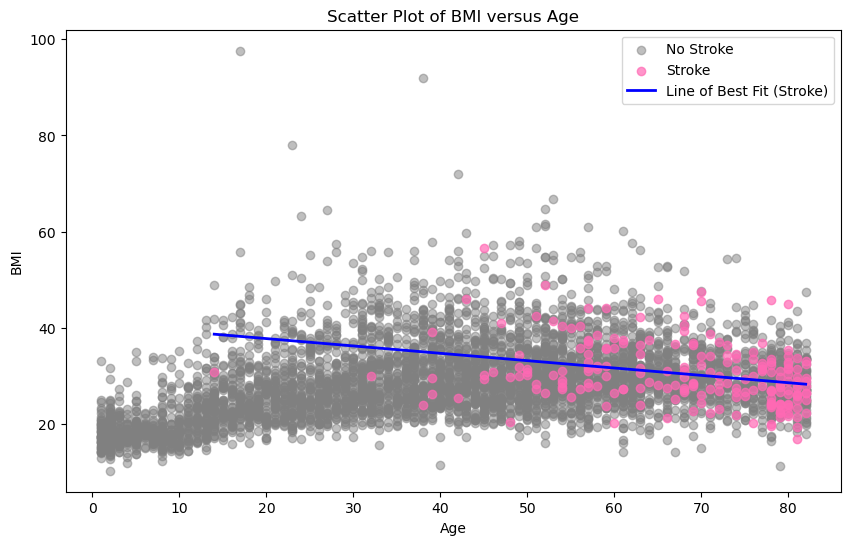

In [19]:
# Scatter plot of BMI versus age with different colors for stroke and no-stroke data
plt.figure(figsize=(10, 6))

# Plot no-stroke data in grey
plt.scatter(x=no_stroke_data['age'], y=no_stroke_data['bmi'], color='grey', alpha=0.5, label='No Stroke')

# Plot stroke data in hot pink
plt.scatter(x=stroke_data['age'], y=stroke_data['bmi'], color='hotpink', alpha=0.7, label='Stroke')

# Line of best fit for stroke data
slope, intercept = np.polyfit(stroke_data['age'], stroke_data['bmi'], 1)
x_vals = np.linspace(min(stroke_data['age']), max(stroke_data['age']), 100)
plt.plot(x_vals, slope * x_vals + intercept, color='blue', linewidth=2, label='Line of Best Fit (Stroke)')

plt.title('Scatter Plot of BMI versus Age')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.legend()

# Save Figure
plt.savefig('Images/bmi_age_scatter.pdf')
plt.show()



In [20]:
# Line of best fit (regression line)
slope, intercept, r_value, p_value, std_err = linregress(stroke_data['age'], stroke_data['bmi'])
x_vals = np.linspace(min(stroke_data['age']), max(stroke_data['age']), 100)

# Display the line equation and R-squared value
equation_1 = f'Line Equation: x = {slope:.2f}y + {intercept:.2f}, R-squared: {r_value**2:.4f}'
print(equation_1)

Line Equation: x = -0.15y + 40.82, R-squared: 0.0897


Weak linear relationship: The low R-squared value indicates a weak linear association between Age and BMI for individuals with a stroke. This means that the age alone is not a strong predictor of BMI, and there might be other factors influencing BMI that are not captured by the linear relationship with age.

## BMI Category Distribution by Stroke Status

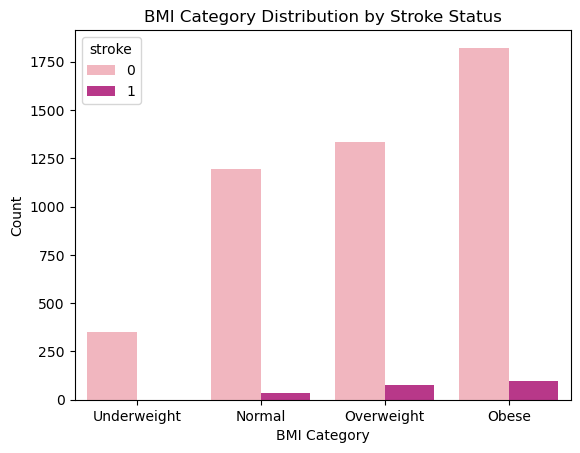

In [21]:
# Exploration of BMI categories
cleaned_df['bmi_category'] = pd.cut(cleaned_df['bmi'], bins=[0, 18.5, 24.9, 29.9, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
sns.countplot(x='bmi_category', hue='stroke', data=cleaned_df, palette='RdPu')
plt.title('BMI Category Distribution by Stroke Status')
plt.xlabel('BMI Category')
plt.ylabel('Count')

# Save Figure
plt.savefig('Images/bmi_category_stroke_bar.pdf')
plt.show()



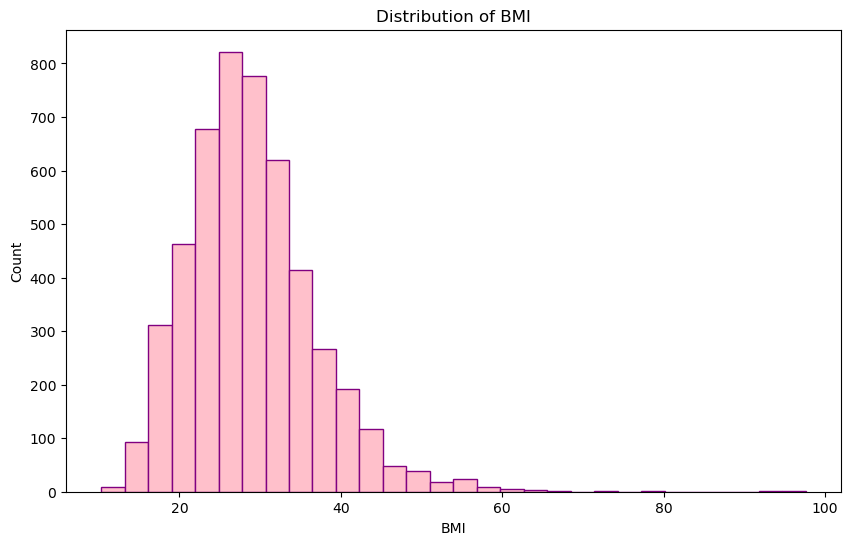

In [22]:
# BMI distribution histogram
plt.figure(figsize=(10, 6))
plt.hist(df['bmi'], bins=30, color='pink', edgecolor='purple')
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Count')

# Save figure
plt.savefig('Images/bmi_distribution.pdf')
plt.show()

Individuals with a stroke, on average, have a slightly higher mean BMI compared to those without a stroke.

The distribution of BMI is narrower among individuals with a stroke, as indicated by the lower standard deviation, suggesting less variability in BMI within this group.

Both groups share a similar median BMI, but individuals without a stroke exhibit a wider range of BMIs, with a higher maximum observed value.

# Average Blood Sugar vs Stroke risk

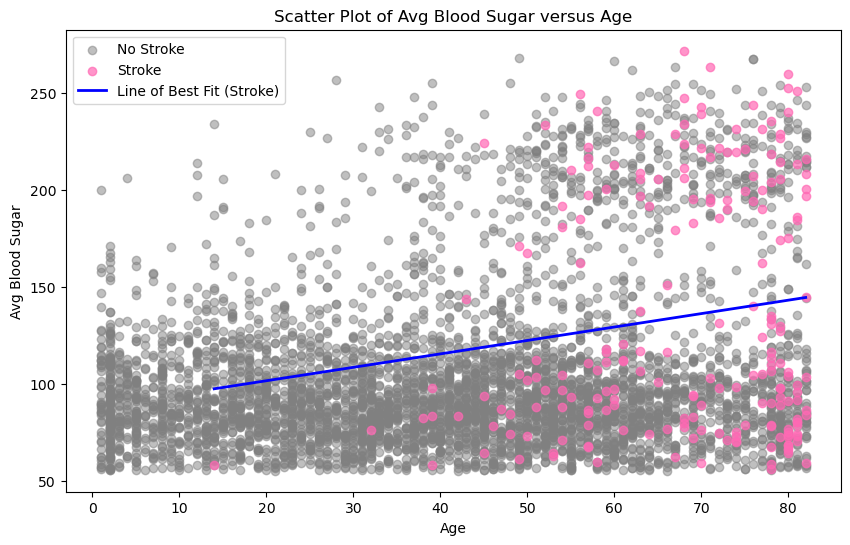

In [33]:
# Scatter plot of blood sugar versus age with different colors for stroke and no-stroke data
plt.figure(figsize=(10, 6))

# Plot no-stroke data in grey
plt.scatter(x=no_stroke_data['age'], y=no_stroke_data['avg_glucose_level'], color='grey', alpha=0.5, label='No Stroke')

# Plot stroke data in hot pink
plt.scatter(x=stroke_data['age'], y=stroke_data['avg_glucose_level'], color='hotpink', alpha=0.7, label='Stroke')

# Line of best fit for stroke data
slope, intercept = np.polyfit(stroke_data['age'], stroke_data['avg_glucose_level'], 1)
x_vals = np.linspace(min(stroke_data['age']), max(stroke_data['age']), 100)
plt.plot(x_vals, slope * x_vals + intercept, color='blue', linewidth=2, label='Line of Best Fit (Stroke)')

plt.title('Scatter Plot of Avg Blood Sugar versus Age')
plt.xlabel('Age')
plt.ylabel('Avg Blood Sugar')
plt.legend()

# Save Figure
plt.savefig('Images/age_sugar_scatter.pdf')
plt.show()

Individuals with a stroke, on average, have a higher mean average blood glucose level compared to those without a stroke.

The average blood glucose level distribution among individuals with a stroke is wider, with a higher standard deviation, suggesting greater variability in blood glucose levels within this group.

Both groups share a similar median average blood glucose level, but individuals with a stroke exhibit a wider range of values, with a higher maximum observed level.

## Histogram of Average Blood Sugar

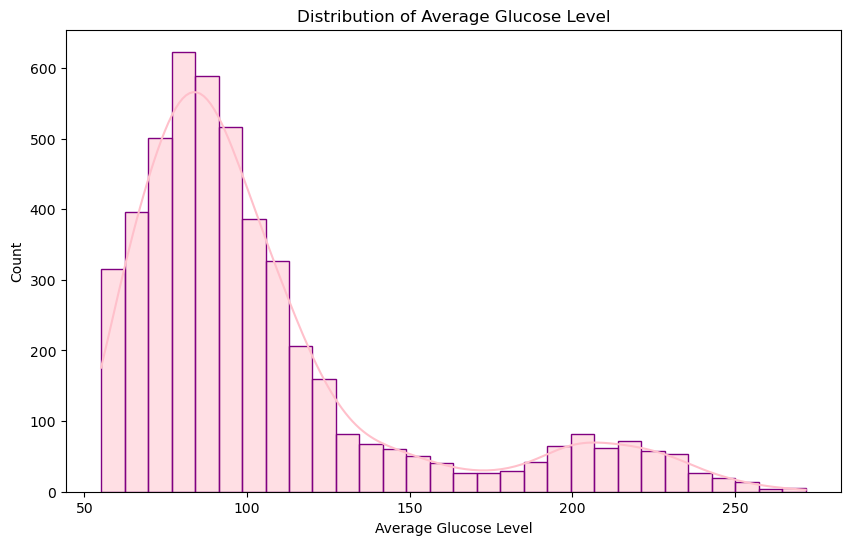

In [24]:
# Create a histogram with KDE for the distribution of average glucose level
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_df['avg_glucose_level'], bins=30, kde=True, color='pink', edgecolor='purple')
plt.title('Distribution of Average Glucose Level')
plt.xlabel('Average Glucose Level')
plt.ylabel('Count')

# Save Figure
plt.savefig('Images/glucose_hist.pdf')
plt.show()

## Scatter plot for Blood Sugar vs BMI stroke

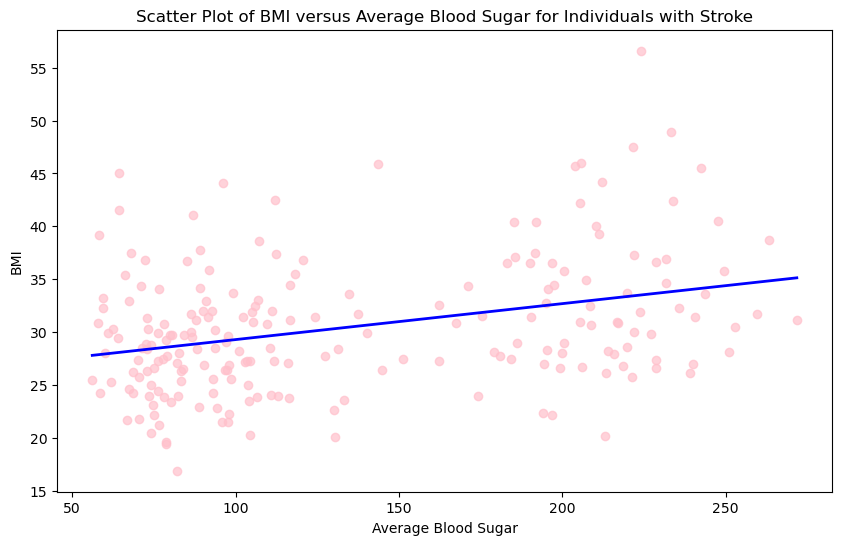

In [25]:
# Scatter plot of BMI versus age with red color for data points
plt.figure(figsize=(10, 6))
plt.scatter(x=stroke_data['avg_glucose_level'], y=stroke_data['bmi'], color='pink', alpha=0.7)

# Line of best fit (regression line)
slope, intercept = np.polyfit(stroke_data['avg_glucose_level'], stroke_data['bmi'], 1)
x_vals = np.linspace(min(stroke_data['avg_glucose_level']), max(stroke_data['avg_glucose_level']), 100)
plt.plot(x_vals, slope * x_vals + intercept, color='blue', linewidth=2, label='Line of Best Fit')

plt.title('Scatter Plot of BMI versus Average Blood Sugar for Individuals with Stroke')
plt.xlabel('Average Blood Sugar')
plt.ylabel('BMI')

# Save Figure
plt.savefig('Images/bmi_glucose_scatter.pdf')
plt.show()


In [26]:
# Line of best fit (regression line)
slope, intercept, r_value, p_value, std_err = linregress(stroke_data['avg_glucose_level'], stroke_data['bmi'])
x_vals = np.linspace(min(stroke_data['avg_glucose_level']), max(stroke_data['avg_glucose_level']), 100)

# Display the line equation and R-squared value
equation_2 = f'Line Equation: x = {slope:.2f}y + {intercept:.2f}, R-squared: {r_value**2:.4f}'
print(equation_2)


Line Equation: x = 0.03y + 25.90, R-squared: 0.1125


In summary, the linear model suggests a modest positive relationship between blood sugar and BMI for individuals who had a stroke. However, the model has limited explanatory power, and other factors not considered in the model may contribute to the variability in blood sugar levels. It's essential to interpret these results cautiously and consider additional factors that may influence blood sugar.